# 事前準備

In [2]:
import psutil
import numpy as np
import pandas as pd
import multiprocessing
import dask.dataframe as ddf
import matplotlib.pyplot as plt

DATA_PATH = '/home/workspace/Tabular_Playground_Series_Dec_2021/data/'

In [5]:
train_data = pd.read_csv(DATA_PATH+'train.csv', dtype=np.float16)
test_data = pd.read_csv(DATA_PATH+'test.csv', dtype=np.float16)

In [7]:
# メモリ容量を取得
mem = psutil.virtual_memory()
print(mem.total)
print(mem.available)

2082197504
349749248


# データの確認

In [8]:
train_data

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,0.0,3188.0,40.0,8.0,30.0,13.0,3270.0,206.0,234.0,193.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,3026.0,182.0,5.0,280.0,29.0,3270.0,233.0,240.0,106.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,2.0,3106.0,13.0,7.0,351.0,37.0,2914.0,208.0,234.0,137.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3.0,3022.0,276.0,13.0,192.0,16.0,3034.0,207.0,238.0,156.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,4.0,2906.0,186.0,13.0,266.0,22.0,2916.0,231.0,231.0,154.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999995,inf,2954.0,34.0,25.0,51.0,65.0,6312.0,240.0,237.0,103.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3999996,inf,2926.0,104.0,8.0,696.0,83.0,5428.0,210.0,216.0,150.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3999997,inf,2912.0,144.0,1.0,509.0,58.0,4820.0,195.0,192.0,91.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
3999998,inf,2580.0,178.0,17.0,376.0,86.0,2592.0,225.0,183.0,39.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


(array([1.468136e+06, 2.262087e+06, 0.000000e+00, 1.957120e+05,
        0.000000e+00, 3.770000e+02, 1.000000e+00, 0.000000e+00,
        1.142600e+04, 6.226100e+04]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ],
       dtype=float16),
 <BarContainer object of 10 artists>)

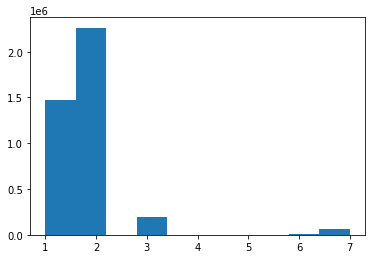

In [7]:
plt.hist(train_data['Cover_Type'])

In [12]:
len(train_data[train_data['Cover_Type']==3]) + len(train_data[train_data['Cover_Type']==4]) + len(train_data[train_data['Cover_Type']==5]) + len(train_data[train_data['Cover_Type']==6]) + len(train_data[train_data['Cover_Type']==7])

269777

In [16]:
len(train_data)

4000000

In [17]:
269777 / 4000000

0.06744425

In [18]:
len(train_data[train_data['Cover_Type']==4])

377

In [19]:
len(train_data[train_data['Cover_Type']==5])

1

In [20]:
len(train_data[train_data['Cover_Type']==6])

11426